# Tests, Tries and Concept

The aim of this notebook is to explore the solutions and build a proof of concept using a small subset of the full dataset to gain time. By doing so, we will get a better understanding of the [NLP pipeline](https://spacy.io/usage/processing-pipelines). We will call this subset of 100 descriptions: _subset_.

In [11]:
# general:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import time # will be use to choose the faster solution
import itertools # used for instance to flatten list of lists
from collections import Counter # e.g. to find most common words
from sklearn.decomposition import PCA
from adjustText import adjust_text # to avoid overlapping text annotations on plots


# NLP:
import spacy
# import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import word2vec
from gensim.test.utils import get_tmpfile # to save custom-trained models



In [3]:
raw_winedata = pd.read_csv("../data/winemag-data-190314.csv").drop("Unnamed: 0", axis=1) # indexes were stored as col
initial_number_of_rows = raw_winedata.shape[0]
print(raw_winedata.shape)
raw_winedata.head()

(141617, 14)


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013.0
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011.0
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013.0
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013.0
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012.0


In [6]:
# random subset of 1000 descriptions
# (in case there is any specific order in the original dataset)
subset = raw_winedata.sample(1000, random_state=51)
print(subset.shape)

(1000, 14)


In [7]:
# one sample for which we will test the recommender:
test_description = raw_winedata.sample(1, random_state=42)
print(list(test_description.description))
print(test_description[['country', 'province', 'region_1', 'variety', 'vintage', 'taster_name', 'points']])

['Velvety-smooth in texture, with well-articulated blackberry jam, cherry, cassis and melted dark chocolate flavors, this Zin is a little too dessert-like and Porty for my palate. But lots of people will love this richly superripe style.']
      country    province region_1    variety  vintage taster_name  points
62414      US  California     Lodi  Zinfandel   2004.0         NaN      86


From now on, we will work with this subset only.

## Data Processing

No need to remove rows with missing values (for now) in this subset, nor to remove duplicate descriptions.

In [8]:
subset.isnull().sum()

country                    0
description                0
designation              286
points                     0
price                     59
province                   0
region_1                 170
region_2                 637
taster_name              158
taster_twitter_handle    196
title                      0
variety                    0
winery                     0
vintage                   31
dtype: int64

In [9]:
duplicates_description  = subset[subset.duplicated(subset='description', keep=False)].sort_values(by='description')
print('number of duplicated descriptions: ', duplicates_description.shape[0]/2)

number of duplicated descriptions:  0.0


## Testing and Understanding spaCy

Some code to test and understanc spaCy on the subset.


In [7]:
nlp = spacy.load('en_core_web_md')

In [21]:
# tokenization:
time0 = time.time()
descriptions = subset['description'].apply(nlp)
print('parser run in:', time.time() - time0, ' s.')

parser run in: 9.63952374458313  s.


In [22]:
# need to cast as list if want to print spaCy Doc objects:
list(descriptions)[0]

A delicious, balanced Pinot Noir. Shows dry, pure flavors of raspberries, cherries, cola and sandalwood, with a delicious, drink-me-now appeal.

In [23]:
for token in list(descriptions)[0]:
    print(token.text, # Text: The original word text.
          token.lemma_, # Lemma: The base form of the word.
          token.pos_, # POS: The simple part-of-speech tag.
          token.tag_, # Tag: The detailed part-of-speech tag.
          token.dep_, # Dep: Syntactic dependency, i.e. the relation between tokens.
          token.shape_, # Shape: The word shape – capitalization, punctuation, digits.
          token.is_alpha, # is alpha: Is the token an alpha character? (alphanumeric)
          token.is_stop # is stop: Is the token part of a stop list, i.e. the most common words of the language?
         )

A a DET DT det X True True
delicious delicious ADJ JJ amod xxxx True False
, , PUNCT , punct , False False
balanced balanced ADJ JJ amod xxxx True False
Pinot Pinot PROPN NNP compound Xxxxx True False
Noir Noir PROPN NNP ROOT Xxxx True False
. . PUNCT . punct . False False
Shows show NOUN NNS ROOT Xxxxx True False
dry dry ADJ JJ amod xxx True False
, , PUNCT , punct , False False
pure pure ADJ JJ amod xxxx True False
flavors flavor NOUN NNS dobj xxxx True False
of of ADP IN prep xx True True
raspberries raspberry NOUN NNS pobj xxxx True False
, , PUNCT , punct , False False
cherries cherry NOUN NNS conj xxxx True False
, , PUNCT , punct , False False
cola cola NOUN NN conj xxxx True False
and and CCONJ CC cc xxx True True
sandalwood sandalwood NOUN NN conj xxxx True False
, , PUNCT , punct , False False
with with ADP IN prep xxxx True True
a a DET DT det x True True
delicious delicious ADJ JJ amod xxxx True False
, , PUNCT , punct , False False
drink drink VERB VB compound xxxx True Fa

In [18]:
# using nlp.pipe: Process the texts as a stream
# and buffer them in batches, instead of one-by-one. 
# This is usually much more efficient.

time0 = time.time()
descriptions = subset['description'].apply(nlp.pipe)
print('parser run in:', time.time() - time0, ' s.')

parser run in: 0.0034329891204833984  s.


Indeed! _nlp.pipe_ is a lot faster than _nlp_!

In [19]:
# but this does not work like this for the output of nlp.pipe
list(descriptions)[0]

<generator object pipe at 0x13a37fcd0>

In [10]:
print("Pipeline", nlp.pipe_names) # the different components of the model, forming the pipeline
# + the tokenizer is not indicated and run at the beginning.

Pipeline ['tagger', 'parser', 'ner']


In [ ]:
spacy.displacy.render(list(descriptions)[0], style='dep')

In [ ]:
# NER not workng... not sure why?
for ent in list(descriptions)[2].ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

In [ ]:
spacy.displacy.serve(list(descriptions)[2], style="ent")
# need to stop kernel to shut down server.

In [ ]:
# print vectors:
for token in list(descriptions)[0]:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

Open [this link](https://spacy.io/usage/rule-based-matching#adding-patterns-attributes) to see what are all the tokens attributes.

In [ ]:
# For now, we just want to tokenize and we will probably not use the parser (POS tags),
# how faster is the processing?
# tokenizing:
time0 = time.time()
descriptions = subset['description'].apply(nlp, disable=["parser"])
print('parser run in:', time.time() - time0, ' s.')


In [ ]:
# if we disable all the components and keep only tokenization:
time0 = time.time()
descriptions = subset['description'].apply(nlp, disable=['tagger', 'parser', 'ner'])
print('parser run in:', time.time() - time0, ' s.')

# a lot faster! That will be important when processing all the descriptions (full dataset)

In [ ]:
# check if we still have the vectors when disabling ['tagger', 'parser', 'ner']
for token in list(descriptions)[0]:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

# WE DO !

In [ ]:
# Each Doc, Span and Token comes with a .similarity() method 
for token1 in list(descriptions)[0][3:4]:
    for token2 in list(descriptions)[0]:
        print(token1.text, token2.text, token1.similarity(token2))

In [ ]:
# vectors for medium model: 20'000 terms and 300 dimensions:
len(nlp.vocab.vectors)

In [ ]:
# the vector of a word in a doc:
list(descriptions)[0][4].vector

In [2]:
# the vector of a doc is the average of all token vectors in the doc:
list(descriptions)[0].vector

NameError: name 'descriptions' is not defined

In [ ]:
# save the Doc for later:
import pickle
pickle.dump(descriptions,  open( "../data/test_save_subset.p", "wb" ))
# The size is huge !

In [ ]:
# try to load the saved Doc:
test = pickle.load( open( "../data/test_save_subset.p", "rb" ) )
print(len(list(test)[0][4].vector))
list(test)[0]


It works! The Doc created, e.g. after tokenization can be saved as pickles, but their size is huge!

## Tokenization
We will use the large model, because we can, and because the vocabulary is larger. However, we only need to tokenize and will not need the PoS tagger, dependecy parser and Named Entities Recognizer.  

We will clean the token after, removing punctuation and stopwords, setting all of them to lower case.

In [176]:
# loading the nlp model. 
time0 = time.time()
nlp = spacy.load('en_core_web_lg', disable=["tagger", "parser", "ner"])
print('model loaded in:', time.time() - time0, ' s.')

model loaded in: 9.209998846054077  s.


In [177]:
# Creating our tokenizer function
def tokenize_and_clean(description):
    
    # Tokenize:
    mytokens = nlp(description)

    # Removing stopwords, punctuation and convert to lower_case
    mytokens = [token.lower_ for token in mytokens if not token.is_punct and not token.is_stop]

    # Return preprocessed list of tokens
    return mytokens


In [14]:
time0 = time.time()

descriptions = subset['description'].apply(tokenize_and_clean) 

# if we want, we can add the parsed descriptions to the dataframe:
subset.loc[:,'description_tokenized'] = descriptions

print('Finished! Tokenization and cleaning took ', time.time() - time0, ' s. to run.')

Finished! Tokenization and cleaning took  0.3312108516693115  s. to run.


In [255]:
# # tokenization and cleaning of descriptions:

# def clean_tokenized_text(doc):
#     # remove stopwords and punctuation,
#     # return the lower case in the form of a list of words (strings):
#     return([token.lower_ for token in doc if not token.is_punct and not token.is_stop]) # [] to not return the generator

# def tokenize_and_clean(texts):
#     # texts is a pd.Series (the description column of the wine dataset)
#     time0 = time.time()
    
#     # using nlp instead of nlp.pipe:
#     descriptions = texts.apply(nlp) # tokenize
#     print('Tokenization took ', time.time() - time0, ' s. to run.')
#     tokenized_serie = descriptions.apply(clean_tokenized_text) # clean text
    
# #     # using nlp.pipe, should be faster:
# #     tokenized_serie = []
# #     for doc in nlp.pipe(texts): 
# #         # clean text:
# #         tokenized_serie.append(clean_tokenized_text(doc))
# #     # returns a list of words per doc
    
#     print('Finished! Tokenization and cleaning took ', time.time() - time0, ' s. to run.')
#     return(tokenized_serie)
    
# descriptions = tokenize_and_clean(subset['description'])
# print(list(descriptions)[0])

Finished! Tokenization and cleaning took  0.22227191925048828  s. to run.
['delicious', 'balanced', 'pinot', 'noir', 'shows', 'dry', 'pure', 'flavors', 'raspberries', 'cherries', 'cola', 'sandalwood', 'delicious', 'drink', 'appeal']


Our descriptions have now the form of a list of list of words, i.e. a list of words per doc. 

Ok, so now let's try some vectorization techniques!

## Bag of Words + Cosine Similarity

In [29]:
# NOT NEEDED:

# # creates corpus based on the tokenized docs:
# time0 = time.time()

# corpus = list(itertools.chain(*descriptions)) # should be faster than solution below
# # corpus = [y for x in descriptions for y in x]

# # the corpus is here a list of all the -clean- words found in the descriptions.

# print('needed time: ', time.time() - time0)
# print('number of words in corpus: ', len(corpus))

In [27]:
# # Utility function to create a list of the n most common words in corpus.
# def bag_of_words(text, n):
#     # Return the n most common words.
#     return [item[0] for item in Counter(text).most_common(n)]

# common_words = bag_of_words(corpus, 3000) # let's start with 3000 most common words

**THIS IS SUPER SLOW AND WILL NOT WORK ON FULL DATA SET ! + it doesn't even work now...**

In [28]:
# # Creates a data frame with features for each word in our common word set.
# # Each value is the count of the times the word appears in each sentence.
# def bow_features(descriptions, common_words):
    
#     # Scaffold the data frame and initialize counts to zero.
#     df = pd.DataFrame(columns=common_words)
#     df['description'] = descriptions
#     df.loc[:, common_words] = 0
#     df = df.reset_index()
    
#     # Process each row, counting the occurrence of words in each sentence.
#     for i, description in enumerate(df['description']):
#         words = [token for token in description]
    
#         # Populate the row with word counts.
#         for word in words:
#             df.loc[i, word] += 1
        
#         # This counter is just to make sure the kernel didn't hang.
#         if i % 50 == 0:
#             print("Processing row {}".format(i))
            
#     return df

# word_counts = bow_features(descriptions, common_words)

Another approach, using sci-kit learn CountVectorizer: 

In [31]:
subset.description

112728    A delicious, balanced Pinot Noir. Shows dry, p...
71255     A zippy, lively nose of citrus and lemon leads...
72503     This style of oak-fermented Verdejo probably d...
110799    On the nose, this has aromas of stone fruit an...
122732    Chardonnay is emerging as a leader at this est...
                                ...                        
37527     This wine is dry, dark and packed with too man...
106043    Clove, star anise and deep strokes of red cher...
124335    The 12 months in wood have given this wine a b...
122578    Snappy black raspberry and young strawberry ar...
1208      Old vines, many up to 80-years-old, supply the...
Name: description, Length: 1000, dtype: object

In [32]:
# 
bow_vector = CountVectorizer(tokenizer = tokenize_and_clean, # using our custom tokenizer
                             ngram_range=(1,1)
                            # NEED TO CHECK DEFAULTS HERE !
                            )

# Applying the vectorizer:
subset_counts = bow_vector.fit_transform(subset.description) # input: the column "description"

In [34]:
# summary (see what was tokenized)
print(type(bow_vector))
print(len(bow_vector.vocabulary_))
print(bow_vector.vocabulary_)

<class 'sklearn.feature_extraction.text.CountVectorizer'>
3985
{'delicious': 1059, 'balanced': 380, 'pinot': 2641, 'noir': 2394, 'shows': 3204, 'dry': 1182, 'pure': 2809, 'flavors': 1450, 'raspberries': 2858, 'cherries': 760, 'cola': 847, 'sandalwood': 3076, 'drink': 1169, 'appeal': 276, 'zippy': 3979, 'lively': 2095, 'nose': 2403, 'citrus': 795, 'lemon': 2029, 'leads': 2010, 'simple': 3220, 'enjoyable': 1267, 'wine': 3906, 'moldova': 2305, 'tongue': 3654, 'clean': 811, 'continue': 912, 'offering': 2456, 'accessible': 160, 'fun': 1555, 'character': 734, 'chilled': 773, 'hot': 1794, 'summer': 3479, 'day': 1032, 'refreshing': 2893, 'light': 2058, 'touch': 3660, 'sweetness': 3520, 'priced': 2748, 'everyday': 1300, 'consumption': 907, 'style': 3450, 'oak': 2437, 'fermented': 1395, 'verdejo': 3783, 'probably': 2758, 'better': 452, 'cool': 924, 'years': 3952, '2009': 38, 'result': 2934, 'smells': 3262, 'bit': 462, 'oxidized': 2520, 'nutty': 2435, 'baked': 377, 'apple': 287, 'scents': 3112, '

In [39]:
print ('Shape of Sparse Matrix: ', subset_counts.shape)
print ('Amount of Non-Zero occurences: ', subset_counts.nnz)
print ('sparsity: %.2f%%' % (100.0 * subset_counts.nnz /
                             (subset_counts.shape[0] * subset_counts.shape[1])))

Shape of Sparse Matrix:  (1000, 3985)
Amount of Non-Zero occurences:  23317
sparsity: 0.59%


In [40]:
# our descriptions have been converted into numeric vectors such that each document 
# is represented by one vector (row) in the above feature matrix. 
cv_matrix = subset_counts.toarray()
print(cv_matrix.shape)
cv_matrix

(1000, 3985)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [61]:
# we can reshape the result to a dataframe so that it is more understandable:
# get all unique words in the corpus
vocab = bow_vector.get_feature_names()
# show document feature vectors
BoW_features = pd.DataFrame(cv_matrix, columns=vocab)
BoW_features

,,$,02,07,1,10,100,100-acre,11.5,12,...,zingy,zinny,zip,zipping,zippy,zucchini,zweigelt,à,—m.m,’s
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# we can add to this dataframe the initial descriptions:
# BoW_features.loc[:, 'raw_description'] = subset.description

# we first set the indexes of the BoW features to the original data:
BoW_features = BoW_features.set_index(subset.index)
BoW_features_with_text = BoW_features.set_index(subset.index)

# then we can add the new column, because indexes are the same:
BoW_features_with_text.insert(0, 'raw_description', subset.description)
BoW_features_with_text

,raw_description,,$,02,07,1,10,100,100-acre,11.5,...,zingy,zinny,zip,zipping,zippy,zucchini,zweigelt,à,—m.m,’s
112728,"A delicious, balanced Pinot Noir. Shows dry, p...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71255,"A zippy, lively nose of citrus and lemon leads...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
72503,This style of oak-fermented Verdejo probably d...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110799,"On the nose, this has aromas of stone fruit an...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
122732,Chardonnay is emerging as a leader at this est...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37527,"This wine is dry, dark and packed with too man...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106043,"Clove, star anise and deep strokes of red cher...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
124335,The 12 months in wood have given this wine a b...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
122578,Snappy black raspberry and young strawberry ar...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We have 3985 features, some look not useful, like "$" , or "07", "-m.m". We should probably:  

* Limit the max number of features when vectorizing, e.g. max_features=2000
* Apply more stringent text cleaning filter in our *tokenize_and_clean* vectorizer. E.g. by removing numbers (digits) or by removing words occuring in less than 2 documents. It is probably fair to remove words occuring in few documents, because taste descriptors are likely to be words occuring multiple times. A taste descriptor occuring only once in more than 100'000 descriptions is basically useless.  
* vocab[0] seem to be a space, it should be removed too.

### Recommender based on BoW only



In [74]:
# example computing similarity between the first 2 wines:
cosine_similarity([BoW_features.iloc[0,:]], [BoW_features.iloc[1,:]])

array([[0.04503773]])

In [83]:
# exactly the same as:
cosine_similarity([subset_counts.toarray()[0,:]], [subset_counts.toarray()[1,:]])

array([[0.04503773]])

In [ ]:
# computing the 

##### Building Similarity Matrix

Pairwise document similarity in a corpus involves computing document similarity for each pair of documents in a corpus. Thus if you have C documents in a corpus, you would end up with a C x C matrix such that each row and column represents the similarity score for a pair of documents, which represent the indices at the row and column, respectively.  

We have 1000 descriptions, the similarity matrix should have dimension 1000x1000.

In [86]:
# generating the cosine similarity matrix
cos_sim_mat = cosine_similarity(subset_counts, subset_counts)
print(cos_sim_mat.shape)
cos_sim_mat

(1000, 1000)


array([[1.        , 0.04503773, 0.08856149, ..., 0.05057217, 0.04356068,
        0.04159452],
       [0.04503773, 1.        , 0.06780635, ..., 0.15488062, 0.1000556 ,
        0.12738595],
       [0.08856149, 0.06780635, 1.        , ..., 0.03806935, 0.06558258,
        0.06262243],
       ...,
       [0.05057217, 0.15488062, 0.03806935, ..., 1.        , 0.        ,
        0.32183934],
       [0.04356068, 0.1000556 , 0.06558258, ..., 0.        , 1.        ,
        0.        ],
       [0.04159452, 0.12738595, 0.06262243, ..., 0.32183934, 0.        ,
        1.        ]])

In [110]:
# we can build a dataframe with the similarity matrix, and have the index of the wines as column names:
df_cos_sim_mat = pd.DataFrame(cos_sim_mat, columns=subset.index, index=subset.index)
df_cos_sim_mat


,112728,71255,72503,110799,122732,67844,93905,33080,86906,139351,...,109069,98015,15725,18986,52318,37527,106043,124335,122578,1208
112728,1.000000,0.045038,0.088561,0.000000,0.126660,0.000000,0.039873,0.000000,0.000000,0.000000,...,0.108465,0.045835,0.084440,0.091670,0.000000,0.062622,0.045835,0.050572,0.043561,0.041595
71255,0.045038,1.000000,0.067806,0.206010,0.096976,0.111417,0.122113,0.030528,0.000000,0.000000,...,0.083045,0.000000,0.064651,0.105279,0.099258,0.095893,0.070186,0.154881,0.100056,0.127386
72503,0.088561,0.067806,1.000000,0.000000,0.127128,0.000000,0.090045,0.060030,0.000000,0.000000,...,0.040825,0.034503,0.031782,0.138013,0.048795,0.000000,0.034503,0.038069,0.065583,0.062622
110799,0.000000,0.206010,0.000000,1.000000,0.096561,0.055470,0.182384,0.091192,0.052414,0.069338,...,0.186052,0.052414,0.048280,0.052414,0.074125,0.143223,0.104828,0.115663,0.099627,0.142695
122732,0.126660,0.096976,0.127128,0.096561,1.000000,0.034816,0.200327,0.085855,0.032898,0.000000,...,0.116775,0.032898,0.060606,0.164488,0.000000,0.044947,0.098693,0.036298,0.093796,0.119416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37527,0.062622,0.095893,0.000000,0.143223,0.044947,0.051640,0.084895,0.212238,0.048795,0.000000,...,0.115470,0.048795,0.000000,0.097590,0.138013,1.000000,0.000000,0.161515,0.000000,0.221404
106043,0.045835,0.070186,0.034503,0.104828,0.098693,0.000000,0.031068,0.062137,0.214286,0.047246,...,0.211289,0.250000,0.131590,0.071429,0.202031,0.000000,1.000000,0.000000,0.237595,0.000000
124335,0.050572,0.154881,0.038069,0.115663,0.036298,0.250217,0.068559,0.068559,0.039406,0.000000,...,0.093250,0.039406,0.000000,0.000000,0.167183,0.161515,0.000000,1.000000,0.000000,0.321839
122578,0.043561,0.100056,0.065583,0.099627,0.093796,0.000000,0.059054,0.029527,0.101827,0.044901,...,0.120483,0.169711,0.125061,0.101827,0.048002,0.000000,0.237595,0.000000,1.000000,0.000000


We can take any wine from the subset and return the top _n_ most similar wines based on the similarity matrix.

In [156]:
def print_wines(wine_indexes):
    # print most important characteristic of wine(s),
    # from their index(es).
    # ! wine_indexes must be a list
    for index_ in wine_indexes:
        current_wine = subset.loc[index_, :]
        print(current_wine[['title', 'country', 'province', 'region_1', 'variety', 
                                'vintage', 'taster_name', 'points']])
        print([current_wine.description])
        print('keywords: ', tokenize_and_clean(current_wine.description))

def print_recommendation(wine_index, n):
    # from the index of a wine, the similarity matrix 
    # as a dataframe with the index of the wines as columns names,
    # returns a number n most similar wines.
    
    # ? eventually add similarity matrix as argument, evtl data too
    
    # selected wine similarity scores:
    wine_sims = df_cos_sim_mat[wine_index] 
    # sort and select top n most similar indexes
    # start at 1 to remove similarity with itself
    wine_sims = wine_sims.sort_values(ascending=False)[1:n+1]
    
    print('You are looking for a similar wine to: ')
    print_wines([wine_index])
    print('\n---------------------------------------- ')
    print('We can recommend you the following wines:')
    print('----------------------------------------- \n')

    for index_ in wine_sims.index:
        print_wines([index_]) # print characteristic of recommended wine
        print('similarity score: ', wine_sims.loc[index_]) # and the similarity score
        print('')
        

    return wine_sims

print_recommendation(112728, 5)
    


You are looking for a similar wine to: 
title          Radog 2007 Radog Pinot Noir (Monterey)
country                                            US
province                                   California
region_1                                     Monterey
variety                                    Pinot Noir
vintage                                          2007
taster_name                                       NaN
points                                             87
Name: 112728, dtype: object
['A delicious, balanced Pinot Noir. Shows dry, pure flavors of raspberries, cherries, cola and sandalwood, with a delicious, drink-me-now appeal.']
keywords:  ['delicious', 'balanced', 'pinot', 'noir', 'shows', 'dry', 'pure', 'flavors', 'raspberries', 'cherries', 'cola', 'sandalwood', 'delicious', 'drink', 'appeal']

---------------------------------------- 
We can recommend you the following wines:
----------------------------------------- 

title          Mana 2006 Pinot Noir (Marlborough)
cou

1492      0.352941
114700    0.313112
37772     0.303170
86091     0.303170
109368    0.264628
Name: 112728, dtype: float64

It does seem gto work so well... Some keywords not related to taste should **maybe** be removed, for instance:

* wine varieties, e.g. "pinot", "cabernet", ... We could use the feature _variety_ from the data as domain-specific stopwords
* "drink"
* "years", "year", 
* "wine"
* consider avoiding splitting words like "easy-to-drink" ?
* consider keeping only 2000 features
* consider removing words comming in more than 95% of descriptions or only once.


## TF-IDF + Cosine Similarity

In [178]:
tfidf_vector = TfidfVectorizer(tokenizer = tokenize_and_clean, # using our custom tokenizer
                               ngram_range=(1,1),
                               max_df=0.95, # ignore t that have a df higher than max_df (corpus-specific stopwords)
                               min_df=2, # ignore terms that have a df lower than threshold.
                               max_features=2000 # (~4000 words in subset)
                            )
# Applying the vectorizer:
subset_tfidf = tfidf_vector.fit_transform(subset.description) # input: the column "description"

In [170]:
# summary (see what was tokenized)
print(type(subset_tfidf))
# dir(subset_tfidf)
# print(len(subset_tfidf.tfidf_))
# print(subset_tfidf.vocabulary_)

<class 'scipy.sparse.csr.csr_matrix'>


In [168]:
print ('Shape of Sparse Matrix: ', subset_tfidf.shape)
print ('Amount of Non-Zero occurences: ', subset_tfidf.nnz)
print ('sparsity: %.2f%%' % (100.0 * subset_tfidf.nnz /
                             (subset_tfidf.shape[0] * subset_tfidf.shape[1])))

Shape of Sparse Matrix:  (1000, 1900)
Amount of Non-Zero occurences:  21232
sparsity: 1.12%


In [172]:
# our descriptions have been converted into numeric vectors such that each document 
# is represented by one vector (row) in the above feature matrix. 
tfidf_matrix = subset_tfidf.toarray()
print(tfidf_matrix.shape)
tfidf_matrix

(1000, 1900)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.23230748,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [181]:
# we can reshape the result to a dataframe so that it is more understandable:
# get all unique words in the corpus
vocab = tfidf_vector.get_feature_names()
# show document feature vectors
tfidf_features = pd.DataFrame(tfidf_matrix, columns=vocab)

# add initial descriptions:
tfidf_features = tfidf_features.set_index(subset.index)
tfidf_features_with_text = tfidf_features.set_index(subset.index)

tfidf_features_with_text.insert(0, 'raw_description', subset.description)
tfidf_features_with_text

,raw_description,,$,1,10,100,12,13,14,15,...,youthful,youthfully,zest,zesty,zin,zinfandel,zingy,zip,zippy,’s
112728,"A delicious, balanced Pinot Noir. Shows dry, p...",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
71255,"A zippy, lively nose of citrus and lemon leads...",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.232307,0.0
72503,This style of oak-fermented Verdejo probably d...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
110799,"On the nose, this has aromas of stone fruit an...",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
122732,Chardonnay is emerging as a leader at this est...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37527,"This wine is dry, dark and packed with too man...",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
106043,"Clove, star anise and deep strokes of red cher...",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
124335,The 12 months in wood have given this wine a b...,0.0,0.0,0.0,0.0,0.0,0.325705,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
122578,Snappy black raspberry and young strawberry ar...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [190]:
# inspecting vocabulary:
print(list(tfidf_features_with_text.columns))

['raw_description', ' ', '$', '1', '10', '100', '12', '13', '14', '15', '16', '17', '18', '2', '20', '2006', '2007', '2009', '2010', '2011', '2012', '2014', '2015', '2016', '2017', '2017–2022', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '22', '23', '25', '26', '28', '2–3', '3', '30', '34', '38', '3–4', '4', '40', '45', '48', '4–5', '5', '50', '57', '58', '60', '70', '77', '80', '85', '90', '93–95', '95', 'abounds', 'abrasive', 'absolutely', 'abundant', 'acacia', 'accent', 'accented', 'accents', 'accessible', 'accompanied', 'achieve', 'acid', 'acidic', 'acidity', 'acids', 'acre', 'acres', 'add', 'added', 'adding', 'addition', 'additional', 'adds', 'aftertaste', 'age', 'aged', 'ager', 'aggressive', 'aging', 'ahead', 'air', 'airing', 'airs', 'albariño', 'alcohol', 'alentejo', 'alicante', 'allied', 'allow', 'allowing', 'allspice', 'alluring', 'almond', 'almonds', 'alongside', 'alpine', 'american', 'amid', 'amounts', 'ample', 'amplifies', 'animal', 'anise', 'aperitif', 

Observations:  

* there are still number and space and stopwords that should be removed (even if we had max_df=0.95 and min_df=2)

### Recommender 

In [193]:
# generating the cosine similarity matrix
cos_sim_mat = cosine_similarity(subset_tfidf, subset_tfidf) # 1000x1000

# dataframe with the similarity matrix, and have the index of the wines as column names and indexes:
df_cos_sim_mat = pd.DataFrame(cos_sim_mat, columns=subset.index, index=subset.index)

print_recommendation(112728, 5)

You are looking for a similar wine to: 
title          Radog 2007 Radog Pinot Noir (Monterey)
country                                            US
province                                   California
region_1                                     Monterey
variety                                    Pinot Noir
vintage                                          2007
taster_name                                       NaN
points                                             87
Name: 112728, dtype: object
['A delicious, balanced Pinot Noir. Shows dry, pure flavors of raspberries, cherries, cola and sandalwood, with a delicious, drink-me-now appeal.']
keywords:  ['delicious', 'balanced', 'pinot', 'noir', 'shows', 'dry', 'pure', 'flavors', 'raspberries', 'cherries', 'cola', 'sandalwood', 'delicious', 'drink', 'appeal']

---------------------------------------- 
We can recommend you the following wines:
----------------------------------------- 

title          Mana 2006 Pinot Noir (Marlborough)
cou

1492      0.288911
37772     0.243552
55644     0.232069
86091     0.231690
109368    0.226090
Name: 112728, dtype: float64


| Recommendation | BoW | tfidf |
|-|-----|-------|
|1|Mana 2006 Pinot Noir (Marlborough) | Mana 2006 Pinot Noir (Marlborough) |
|2|Merryvale 2009 Starmont Cabernet Sauvignon (Napa Valley) | Kuleto Estate 2006 Rosato Sangiovese (Napa Valley |
|3|Kuleto Estate 2006 Rosato Sangiovese (Napa Vallley) | Alexander Valley Vineyards 2010 Cyrus Red (Ale...) |
|4|Walt 2011 Gap's Crown Pinot Noir (Sonoma Coast) | Walt 2011 Gap's Crown Pinot Noir (Sonoma Coast) |
|5|Longboard 2008 Syrah (Russian River Valley) | Longboard 2008 Syrah (Russian River Valley) |

The recommendations are surprisingly similar! That is not much better...

### Removing Corpus-Specific Stopwords

We saw that we could be better at text cleaning. Will the output radically change?

In [4]:
domain_specific_stopwords = ['$', ' ', '’s', 'wine', 'winemaker', 'winemaking', 'winery']

# a list of all wine varieties. this is not perfect as some varieties are compound words. But it's a start.
variety_stopwords = raw_winedata.variety.unique().tolist()
variety_stopwords = [str(variety).lower() for variety in variety_stopwords] # convert to lowercase
variety_stopwords.append('pinot') # as frequent and only happens as compound word

In [356]:
# # Updating our tokenizer function:
# def tokenize_and_clean(remove_domain_specific_stopwords, remove_variety_stopwords, description):
    
#     try:
#         if (isinstance(remove_domain_specific_stopwords, bool) == False) | \
#         (isinstance(remove_variety_stopwords, bool) == False):
#             raise ValueError
#     except ValueError:
#         print('ValueError: Please enter a boolean for remove_domain_specific_stopwords and remove_variety_stopwords')
#         raise
        
#     # Tokenize:
#     mytokens = nlp(description)

#     # Removing stopwords, punctuation and convert to lower_case + AND NUMBERS (or use is_digit?)
#     mytokens = [token.lower_ for token in mytokens if not token.is_punct and not token.is_stop and not token.like_num]
    
#     # remove domain-specific stopwords:
#     if (remove_domain_specific_stopwords == True):
#         mytokens = [token for token in mytokens if token not in domain_specific_stopwords]
            
    
#     # remove wine variety occurrences in the descriptions:
#     if (remove_variety_stopwords == True):
#         mytokens = [token for token in mytokens if token not in variety_stopwords]
                
#     # Return preprocessed list of tokens
#     return mytokens


In [5]:
# Updating our tokenizer function:
def tokenize_and_clean(description):

    # Tokenize:
    mytokens = nlp(description)

    # Removing stopwords, punctuation and convert to lower_case + AND NUMBERS (or use is_digit?)
    mytokens = [token.lower_ for token in mytokens if not token.is_punct and not token.is_stop and not token.like_num]
    
    # remove domain-specific stopwords:
    mytokens = [token for token in mytokens if token not in domain_specific_stopwords]
            
    # remove wine variety occurrences in the descriptions:
    mytokens = [token for token in mytokens if token not in variety_stopwords]
                
    # Return preprocessed list of tokens
    return mytokens

In [367]:
tfidf_vector = TfidfVectorizer(tokenizer = tokenize_and_clean, # using our custom tokenizer
                               ngram_range=(1,1),
                               max_df=0.95, # ignore t that have a df higher than max_df (corpus-specific stopwords)
                               min_df=2, # ignore terms that have a df lower than threshold.
                               max_features=2000 # (~4000 words in subset)
                            )
# Applying the vectorizer:
subset_tfidf = tfidf_vector.fit_transform(subset.description) # input: the column "description"

# generating the cosine similarity matrix
cos_sim_mat = cosine_similarity(subset_tfidf, subset_tfidf) # 1000x1000

# dataframe with the similarity matrix, and have the index of the wines as column names and indexes:
df_cos_sim_mat = pd.DataFrame(cos_sim_mat, columns=subset.index, index=subset.index)

print_recommendation(112728, 5)

You are looking for a similar wine to: 
title          Radog 2007 Radog Pinot Noir (Monterey)
country                                            US
province                                   California
region_1                                     Monterey
variety                                    Pinot Noir
vintage                                          2007
taster_name                                       NaN
points                                             87
Name: 112728, dtype: object
['A delicious, balanced Pinot Noir. Shows dry, pure flavors of raspberries, cherries, cola and sandalwood, with a delicious, drink-me-now appeal.']
keywords:  ['delicious', 'balanced', 'noir', 'shows', 'dry', 'pure', 'flavors', 'raspberries', 'cherries', 'cola', 'sandalwood', 'delicious', 'drink', 'appeal']

---------------------------------------- 
We can recommend you the following wines:
----------------------------------------- 

title          Alexander Valley Vineyards 2010 Cyrus Red (Ale.

55644     0.252846
1492      0.249453
109368    0.239001
136684    0.229982
37772     0.218677
Name: 112728, dtype: float64

The wine we are trying to find a recommendation for: Radog 2007 Radog Pinot Noir (Monterey). Again, the recommended wines are similar.  

| Recommendation | BoW | tfidf | tfidf - corpus-specific stopwords |
|-|-----|-------|------|
|1|Mana 2006 Pinot Noir (Marlborough) | Mana 2006 Pinot Noir (Marlborough) | Alexander Valley Vineyards 2010 Cyrus Red (Ale...|
|2|Merryvale 2009 Starmont Cabernet Sauvignon (Napa Valley) | Kuleto Estate 2006 Rosato Sangiovese (Napa Valley | Mana 2006 Pinot Noir (Marlborough)|
|3|Kuleto Estate 2006 Rosato Sangiovese (Napa Vallley) | Alexander Valley Vineyards 2010 Cyrus Red (Ale...) | Longboard 2008 Syrah (Russian River Valley)|
|4|Walt 2011 Gap's Crown Pinot Noir (Sonoma Coast) | Walt 2011 Gap's Crown Pinot Noir (Sonoma Coast) | Ermisch 2016 Erendira's Rise Pinot Noir (Willa...|
|5|Longboard 2008 Syrah (Russian River Valley) | Longboard 2008 Syrah (Russian River Valley) | Kuleto Estate 2006 Rosato Sangiovese (Napa Val...|   


  
Let's look at the keywords: 

Input wine:  
* 'delicious', 'balanced', 'noir', 'shows', 'dry', 'pure', 'flavors', 'raspberries', 'cherries', 'cola', 'sandalwood', 'delicious', 'drink', 'appeal'

Recommendations:
1. 'cyrus', 'highest', 'expression', 'shows', 'softness', 'slight', 'herbaceousness', 'alexander', 'valley', 'rich', 'delicious', 'blackberries', 'cherries', 'currants', 'sandalwood', 'blended', 'classic', 'bordeaux', 'varieties', 'holds', 'subtle', 'complexity'
2. 'soft', 'easy', 'drink', 'noir', 'marlborough', 'tannins', 'developed', 'supple', 'flavors', 'lean', 'caramel', 'cherry', 'sandalwood', 'drink'
3. 'wonderful', 'drinkable', 'market', 'delicious', 'thick', 'soft', 'tannins', 'housing', 'dry', 'complex', 'flavors', 'blackberries', 'black', 'currants', 'cola', 'anise', 'black', 'pepper'
4. 'light', 'forward', 'fills', 'mouth', 'texture', 'rich', 'flavor', 'gentle', 'highlights', 'raspberries', 'cherries', 'come', 'wash', 'chocolate', 'malt', 'streak', 'cola', 'drink', 'years'
5. 'blend', 'zin', 'varieties', 'fruit', 'forward', 'fans', 'wealth', 'cherries', 'raspberries', 'cola', 'peppermint', 'candy', 'flavors'

In [375]:
def common_member(a, b): 
    a_set = set(a) 
    b_set = set(b) 
    if (a_set & b_set): 
        return(a_set & b_set) 
    else: 
        return("No common elements") 

input_keywords = ['delicious', 'balanced', 'noir', 'shows', 'dry', 'pure', 'flavors', 'raspberries', 
                  'cherries', 'cola', 'sandalwood', 'delicious', 'drink', 'appeal']
recom_1 = ['cyrus', 'highest', 'expression', 'shows', 'softness', 'slight', 'herbaceousness', 
           'alexander', 'valley', 'rich', 'delicious', 'blackberries', 'cherries', 'currants', 
           'sandalwood', 'blended', 'classic', 'bordeaux', 'varieties', 'holds', 'subtle', 'complexity']
recom_2 = ['soft', 'easy', 'drink', 'noir', 'marlborough', 'tannins', 'developed', 'supple', 'flavors', 
           'lean', 'caramel', 'cherry', 'sandalwood', 'drink']
recom_3 = ['wonderful', 'drinkable', 'market', 'delicious', 'thick', 'soft', 'tannins', 'housing', 'dry', 
           'complex', 'flavors', 'blackberries', 'black', 'currants', 'cola', 'anise', 'black', 'pepper']
recom_4 = ['light', 'forward', 'fills', 'mouth', 'texture', 'rich', 'flavor', 'gentle', 'highlights', 
           'raspberries', 'cherries', 'come', 'wash', 'chocolate', 'malt', 'streak', 'cola', 'drink', 'years']
recom_5 = ['blend', 'zin', 'varieties', 'fruit', 'forward', 'fans', 'wealth', 'cherries', 'raspberries', 
           'cola', 'peppermint', 'candy', 'flavors']

print('common tokens with recom 1: ', common_member(input_keywords, recom_1))
print('common tokens with recom 2: ', common_member(input_keywords, recom_2))
print('common tokens with recom 3: ', common_member(input_keywords, recom_3))
print('common tokens with recom 4: ', common_member(input_keywords, recom_4))
print('common tokens with recom 5: ', common_member(input_keywords, recom_5))

common tokens with recom 1:  {'shows', 'cherries', 'delicious', 'sandalwood'}
common tokens with recom 2:  {'drink', 'noir', 'flavors', 'sandalwood'}
common tokens with recom 3:  {'delicious', 'cola', 'flavors', 'dry'}
common tokens with recom 4:  {'drink', 'cola', 'cherries', 'raspberries'}
common tokens with recom 5:  {'cola', 'cherries', 'flavors', 'raspberries'}


In the end, this does not look too bad. There are some common words that are relevant.  

Maybe "flavors", "drink", "noir" should be removed?

## Word2vec

In [686]:
descriptions = []
for descr in subset['description'].tolist():
    clean_descr = tokenize_and_clean(descr) # parse and clean
    clean_descr = " ".join(clean_descr)
    descriptions.append(clean_descr) # returns a list of string

descriptions = pd.Series(descriptions).apply(nlp) # apply spaCy model again to get word2vec vector

In [687]:
descriptions_vectors = [descr.vector for descr in descriptions]

In [525]:
n_dim_vectors = len(descriptions_vectors[0])
print('features are', n_dim_vectors, 'dimensions vectors') # features are 300 dimensions vectors

# create features names
features_names = list(range(0, n_dim_vectors))
features_names = ['f'+str(i) for i in features_names]

# create a dataframe with features (word2vec vectors) as columns and wine indexes as index
features = pd.DataFrame(descriptions_vectors, columns=features_names, index=subset.index)
features

features are 300 dimensions vectors


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f290,f291,f292,f293,f294,f295,f296,f297,f298,f299
112728,-0.199661,0.165331,0.092081,-0.186038,0.046264,0.237739,-0.115873,0.083883,-0.008285,0.995265,...,0.010443,0.220170,-0.203419,-0.195774,-0.359466,-0.047686,0.224459,-0.659669,0.163287,0.014144
71255,-0.037564,0.197055,-0.017413,-0.021426,0.197736,0.049436,0.026504,0.081384,0.065296,1.414902,...,-0.128407,0.084993,-0.120677,-0.089499,-0.098753,0.006326,0.116289,-0.332213,-0.085977,0.142363
72503,-0.075052,0.126984,-0.075835,-0.070660,-0.071499,0.072585,-0.119931,-0.021146,-0.006173,1.076261,...,-0.016240,0.166342,-0.252028,-0.136293,-0.170988,0.056416,0.088400,-0.390334,-0.052018,0.133324
110799,-0.023622,0.286898,-0.233954,-0.130647,-0.063467,-0.009017,0.087184,0.221726,-0.033202,1.257998,...,-0.148867,0.114271,-0.303072,-0.049767,-0.128971,0.015058,0.132551,-0.223417,-0.023356,0.054666
122732,-0.058398,0.067971,-0.016625,-0.106379,0.113003,0.002206,0.024479,0.132111,0.014302,1.424947,...,-0.142261,0.085213,-0.181861,-0.132790,-0.229590,0.068584,0.038357,-0.366877,0.026836,0.100916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37527,-0.008401,0.209597,-0.193243,-0.033865,0.076589,0.025017,0.043905,0.201371,0.013321,1.628313,...,-0.185177,0.085365,-0.296491,-0.191411,-0.341225,0.188542,0.288020,-0.320600,0.033849,-0.142537
106043,-0.052008,0.221692,-0.165206,-0.158201,0.231252,-0.018306,-0.145829,0.135734,0.032860,0.880025,...,0.035817,0.133436,-0.251760,-0.163240,-0.210474,-0.068962,0.063723,-0.412008,0.011077,0.107108
124335,-0.097208,0.041419,-0.014862,-0.138296,-0.028870,0.118864,0.105857,-0.021384,-0.107842,1.423475,...,-0.168411,0.128699,-0.142083,-0.107650,-0.156200,0.056772,0.050724,-0.318278,0.045403,0.018586
122578,-0.103502,0.094163,-0.151182,-0.040023,0.198364,0.105330,-0.127877,0.074503,0.035774,0.577270,...,-0.037989,0.154049,-0.174628,-0.265767,-0.270800,-0.048573,0.189565,-0.499342,-0.011586,0.167270


In [526]:
# generating the cosine similarity matrix
cos_sim_mat = cosine_similarity(features, features) # 1000x1000

# dataframe with the similarity matrix, and have the index of the wines as column names and indexes:
df_cos_sim_mat = pd.DataFrame(cos_sim_mat, columns=subset.index, index=subset.index)

print_recommendation(112728, 5)

You are looking for a similar wine to: 
title          Radog 2007 Radog Pinot Noir (Monterey)
country                                            US
province                                   California
region_1                                     Monterey
variety                                    Pinot Noir
vintage                                          2007
taster_name                                       NaN
points                                             87
Name: 112728, dtype: object
['A delicious, balanced Pinot Noir. Shows dry, pure flavors of raspberries, cherries, cola and sandalwood, with a delicious, drink-me-now appeal.']
keywords:  ['delicious', 'balanced', 'noir', 'shows', 'dry', 'pure', 'flavors', 'raspberries', 'cherries', 'cola', 'sandalwood', 'delicious', 'drink', 'appeal']

---------------------------------------- 
We can recommend you the following wines:
----------------------------------------- 

title          Kontos 2013 Alatus Red (Walla Walla Valley (WA)

43470     0.927947
102606    0.923146
10672     0.922646
37772     0.921584
59461     0.917384
Name: 112728, dtype: float64

| Recommendation | tfidf - corpus-specific stopwords | word2vec (- corpus-specific stopwords) |
|-|------|------|
|1|Alexander Valley Vineyards 2010 Cyrus Red (Ale...|Kontos 2013 Alatus Red (Walla Walla Valley (WA))|
|2|Mana 2006 Pinot Noir (Marlborough)|Quinta do Ameal 2010 Ameal S.H. White (Portugu...|
|3|Longboard 2008 Syrah (Russian River Valley)|Black Hills 2012 Nota Bene Red (Okanagan Valley)|
|4|Ermisch 2016 Erendira's Rise Pinot Noir (Willa...|Kuleto Estate 2006 Rosato Sangiovese (Napa Val...|
|5|Kuleto Estate 2006 Rosato Sangiovese (Napa Val...|Viña Tabalí 2010 Late Harvest Muscat (Limarí V...|

In [486]:
recom_1 = ['blend', 'aromas', 'macerated', 'cherries', 'baking', 'spice', 'cranberry', 'followed', 
           'sweet', 'fruit', 'flavors', 'brings', 'slight', 'sense', 'astringency', 'delivers', 'goods']
recom_2 = ['rare', 'dessert', 'vinho', 'verde', 'region', 'packed', 'flavors', 'currant', 'lemon', 
           'honey', 'orange', 'peel', 'great', 'sense', 'acidity', 'sweet', 'deliciously', 'refreshing']
recom_3 = ['superstar', 'bordeaux', 'style', 'blend', 'defining', 'red', 'wines', 'okanagan', 'youth', 
           'peppery', 'tannic', 'tough', 'strong', 'herbal', 'flavors', 'pomegranate', 'cranberry', 
           'white', 'raspberry', 'fruit', 'firmly', 'acidic', 'lightly', 'toasty', 'complex', 'finished', 
           'flavors', 'coffee', 'grounds', 'cacao', 'baking', 'spices', 'smoke', 'drink']
recom_4 = ['blend', 'zin', 'varieties', 'fruit', 'forward', 'fans', 'wealth', 'cherries', 'raspberries', 
           'cola', 'peppermint', 'candy', 'flavors']
recom_5 = ['overachiever', 'dessert', 'wines', 'opens', 'ripe', 'sweet', 'stone', 'fruit', 'aromas', 
           'overly', 'challenging', 'heavy', 'palate', 'thick', 'offers', 'right', 'acidity', 'frames', 
           'sweet', 'enjoyable', 'orange', 'lychee', 'honey', 'flavors', 'rich', 'bright', 'extreme']

print('common tokens with recom 1: ', common_member(input_keywords, recom_1))
print('common tokens with recom 2: ', common_member(input_keywords, recom_2))
print('common tokens with recom 3: ', common_member(input_keywords, recom_3))
print('common tokens with recom 4: ', common_member(input_keywords, recom_4))
print('common tokens with recom 5: ', common_member(input_keywords, recom_5))

common tokens with recom 1:  {'cherries', 'flavors'}
common tokens with recom 2:  {'flavors'}
common tokens with recom 3:  {'drink', 'flavors'}
common tokens with recom 4:  {'cola', 'cherries', 'flavors', 'raspberries'}
common tokens with recom 5:  {'flavors'}


Interesting: Not many keywords in common. And the most common keywords in common is not really significant: "flavors". It must maybe be included in the list of *domain_specific_stopwords*.   

It appears, when looking at the example below, that tast/food -specific keywords are similar in the word2vec pre-trained model... This is probably because the context is which they appear is really similar. Would it be better to train a word2vec model on this corpus?

In [527]:
# play a bit with the model:
# the similarity between the tokens of the first description and the token for "Lemon"
for token in descriptions[0]:
    print(token, token.similarity(nlp("lemon"))) # Lemon

delicious 0.5098717234488118
balanced 0.28585355832628606
noir 0.1975107800911662
shows 0.08058456079657775
dry 0.4531798605768059
pure 0.34171554504845636
flavors 0.5280062271309265
raspberries 0.6093142341790713
cherries 0.619689559553382
cola 0.4537385110753809
sandalwood 0.44106119628343177
delicious 0.5098717234488118
drink 0.4341197802260533
appeal 0.15864113123409426


### Training a word2vec model on the corpus

In [9]:
# need to clean and tokenize the full dataset. Let's see if our new method is faster:
time0 = time.time()

descriptions = raw_winedata['description'].apply(tokenize_and_clean)

print('Done! It took ', time.time()-time0, 'sec.')

Done! It took  1342.132733821869 sec.


In [19]:
descriptions_tokenized = pd.Series(descriptions)
descriptions_tokenized.to_csv(path_or_buf='../data/descriptions_tokenized.csv', header=False)

In [20]:
print('we have', len(descriptions), 'descriptions in corpus.')

we have 141617 descriptions in corpus.


In [12]:
# train the word2vec model on the wine descriptions corpus:
time0 = time.time()

custom_wine_word2vec_model = word2vec.Word2Vec(
    descriptions,
    workers=8,     # Number of threads to run in parallel (if your computer does parallel processing).
    min_count=2,   # Minimum word count threshold. ! need to be the same as for tokenize_and_clean
    window=6,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3 ,  # Penalize frequent words.
    size=300,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)

print('Done! It took ', time.time()-time0, 'sec.')

Done! It took  22.249361991882324 sec.


In [ ]:
# summary of model:
print(custom_wine_word2vec_model)

In [23]:
# List of words in model.
vocab = custom_wine_word2vec_model.wv.vocab.keys()

In [24]:
# Most similar words:
custom_wine_word2vec_model.wv.most_similar('flavors')[:5]

[('notes', 0.504328191280365),
 ('flavored', 0.5029716491699219),
 ('flavor', 0.4796287715435028),
 ('accents', 0.42478007078170776),
 ('tastes', 0.4225712716579437)]

Maybe it could make sense to not remove the varieties? So we could try someting like this:

In [25]:
# custom_wine_word2vec_model.most_similar('pinot')[:5] # (currently pinot not in corpus)

In [26]:
custom_wine_word2vec_model.wv.most_similar('fruit')[:10]

[('fruits', 0.6732168197631836),
 ('fruitiness', 0.4242386221885681),
 ('fruited', 0.38682714104652405),
 ('plum', 0.37264102697372437),
 ('red-', 0.37196677923202515),
 ('fruity', 0.36736464500427246),
 ('cherry', 0.3562149405479431),
 ('currant', 0.31561097502708435),
 ('-ruit', 0.3095040023326874),
 ('berries', 0.30880430340766907)]

In [27]:
custom_wine_word2vec_model.wv.most_similar('coffee')[:10]

[('espresso', 0.7060422897338867),
 ('carob', 0.39773473143577576),
 ('coconut', 0.3900386095046997),
 ('chocolaty', 0.37561726570129395),
 ('charcoal', 0.3550891876220703),
 ('cappuccino', 0.3542875051498413),
 ('char', 0.35194581747055054),
 ('cassis', 0.3483140170574188),
 ('mocha', 0.3455159366130829),
 ('disguise', 0.3448752164840698)]

Let's try to visualize the model in 2D using PCA:

In [665]:
X = custom_wine_word2vec_model[custom_wine_word2vec_model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

/Users/dla/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


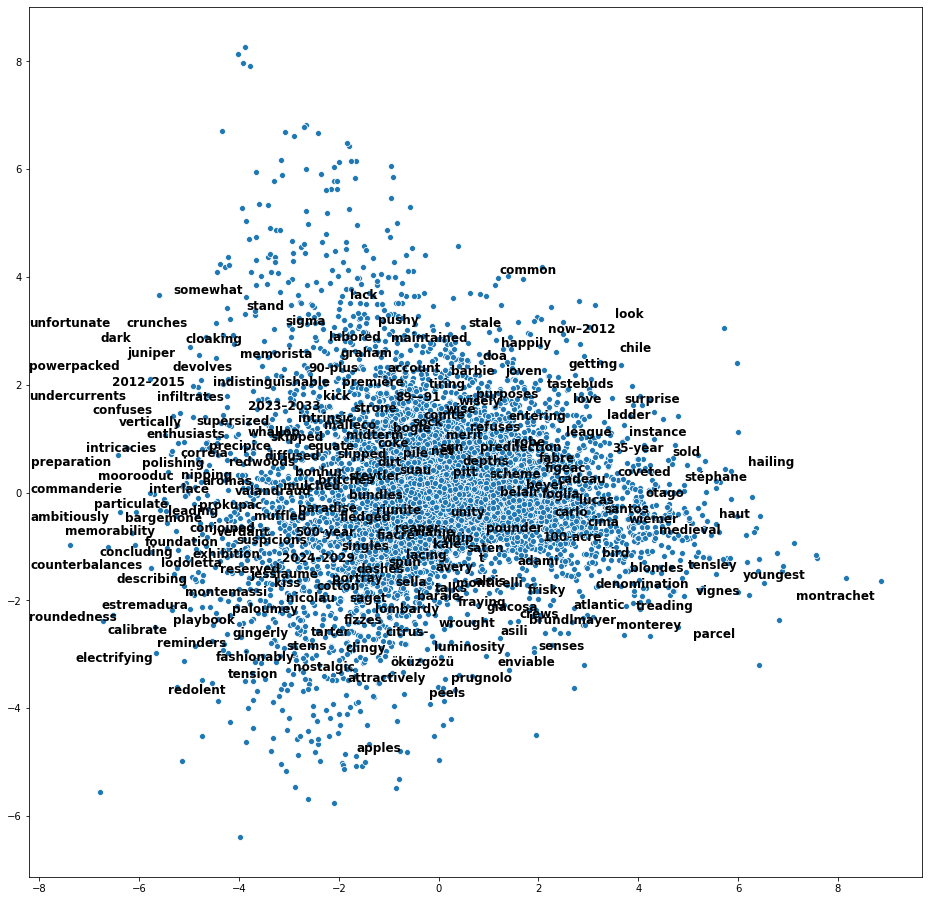

plotted in 154.95641207695007 seconds


In [666]:
# plot the vocabulary of the trained model in 2D.
# takes time to run because of "adjust_text"

time0 = time.time()

plt.figure(figsize=(16, 16))
p = sns.scatterplot(result[:, 0], result[:, 1])
# add annotations one by one with a loop
texts=[]
for line in range(0,result.shape[0]):
    if line % 100 == 0: # annotate only some words
        texts.append(plt.text(result[line, 0], result[line, 1], 
                              list(custom_wine_word2vec_model.wv.vocab)[line], 
                              horizontalalignment='center', size='large', 
                              color='black', weight='semibold'))
# adjust_text(texts, autoalign='xy', expand_objects=(0.1, 1),
#             only_move={'points':'', 'text':'y', 'objects':'y'}, force_text=0.75, force_objects=0.1)
adjust_text(texts)
plt.show()

print("plotted in", time.time()-time0, "seconds")

In [ ]:
# could also try this:

# from sklearn.manifold import TSNE
# X_tsne = TSNE(n_components=2, verbose=2).fit_transform(X)

This looks promising! Let's try the recommendations with this new model. We average the word vectors to get one vector per description.  

In [28]:
time0 = time.time()
descr_vectors = [None] * descriptions.shape[0]
for i, desc in enumerate(descriptions):
    # average vector for each word to get 1 vector per description:
    descr_vectors[i] = np.mean([custom_wine_word2vec_model.wv[word] for word in descriptions[0]], axis=0) # axis needed to keep 300 dim.
print('done in sec: ', time.time()-time0)

done in sec:  9.790066957473755


In [29]:
# create features names
features_names = list(range(0, len(descr_vectors[0])))
features_names = ['f'+str(i) for i in features_names]

time0 = time.time()

# create a dataframe with features (word2vec vectors) as columns and wine indexes as index
features = pd.DataFrame(descr_vectors, columns=features_names, index=raw_winedata.index)

print('done in sec: ', time.time()-time0)

done in sec:  18.059414863586426


In [ ]:
time0 = time.time()

# generating the cosine similarity matrix
cos_sim_mat = cosine_similarity(features, features) # 141617X141617

# dataframe with the similarity matrix, and have the index of the wines as column names and indexes:
df_cos_sim_mat = pd.DataFrame(cos_sim_mat, columns=raw_winedata.index, index=raw_winedata.index)
 
print('done in sec: ', time.time()-time0)

In [704]:
df_cos_sim_mat.shape

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f290,f291,f292,f293,f294,f295,f296,f297,f298,f299
0,0.06823,0.435379,-0.588368,-0.269807,0.190669,-0.251721,-0.003861,0.334827,0.077174,-0.434145,...,0.157013,0.044958,0.252005,-0.242746,-0.125334,1.030934,-0.390582,0.780088,-0.056152,0.700056
1,0.06823,0.435379,-0.588368,-0.269807,0.190669,-0.251721,-0.003861,0.334827,0.077174,-0.434145,...,0.157013,0.044958,0.252005,-0.242746,-0.125334,1.030934,-0.390582,0.780088,-0.056152,0.700056
2,0.06823,0.435379,-0.588368,-0.269807,0.190669,-0.251721,-0.003861,0.334827,0.077174,-0.434145,...,0.157013,0.044958,0.252005,-0.242746,-0.125334,1.030934,-0.390582,0.780088,-0.056152,0.700056
3,0.06823,0.435379,-0.588368,-0.269807,0.190669,-0.251721,-0.003861,0.334827,0.077174,-0.434145,...,0.157013,0.044958,0.252005,-0.242746,-0.125334,1.030934,-0.390582,0.780088,-0.056152,0.700056
4,0.06823,0.435379,-0.588368,-0.269807,0.190669,-0.251721,-0.003861,0.334827,0.077174,-0.434145,...,0.157013,0.044958,0.252005,-0.242746,-0.125334,1.030934,-0.390582,0.780088,-0.056152,0.700056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141612,0.06823,0.435379,-0.588368,-0.269807,0.190669,-0.251721,-0.003861,0.334827,0.077174,-0.434145,...,0.157013,0.044958,0.252005,-0.242746,-0.125334,1.030934,-0.390582,0.780088,-0.056152,0.700056
141613,0.06823,0.435379,-0.588368,-0.269807,0.190669,-0.251721,-0.003861,0.334827,0.077174,-0.434145,...,0.157013,0.044958,0.252005,-0.242746,-0.125334,1.030934,-0.390582,0.780088,-0.056152,0.700056
141614,0.06823,0.435379,-0.588368,-0.269807,0.190669,-0.251721,-0.003861,0.334827,0.077174,-0.434145,...,0.157013,0.044958,0.252005,-0.242746,-0.125334,1.030934,-0.390582,0.780088,-0.056152,0.700056
141615,0.06823,0.435379,-0.588368,-0.269807,0.190669,-0.251721,-0.003861,0.334827,0.077174,-0.434145,...,0.157013,0.044958,0.252005,-0.242746,-0.125334,1.030934,-0.390582,0.780088,-0.056152,0.700056


## Doc2vec

Try to train a model later :  
https://medium.com/scaleabout/a-gentle-introduction-to-doc2vec-db3e8c0cce5e
https://towardsdatascience.com/understand-how-to-transfer-your-paragraph-to-vector-by-doc2vec-1e225ccf102